# Good position to live or open a restaurant in HaiKou

In [2]:
# import needed lib

# for dataframe
import pandas as pd
import numpy as np

# for graphic
import requests
from pandas.io.json import json_normalize
import folium

# for dataplots
%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import gridspec


## 1. Check and Prepare the original data

In [3]:
# Read data from the file (collected from many sources on internet)
Haikou_GDP = pd.read_excel(r'C:\Users\Xiang Fu\Desktop\Haikou\GDP.xlsx')
Haikou_NBH = pd.read_excel(r'C:\Users\Xiang Fu\Desktop\Haikou\Neighborhood.xlsx')
Haikou_POP = pd.read_excel(r'C:\Users\Xiang Fu\Desktop\Haikou\Population.xlsx')

In [4]:
Haikou_GDP= Haikou_GDP.dropna()
Haikou_GDP

,District,Postal code,Population (Tenth of Thousands),Area (Square Kilometres),GDP (Tenth of Thousands RMB),GDP Per Capital (RMB),salary (RMB),Home Price (RMB)
0,LongHua,570100.0,66.98,300.6,6873900.0,102626.157062,34220.0,14664
1,XiuYing,570300.0,38.78,511.5,2202000.0,56781.846313,30428.0,16826
2,QiongShan,571100.0,51.17,939.9,1700600.0,33234.316983,31405.0,13669
3,MeiLan,570200.0,70.28,552.8,3640000.0,51792.828685,31503.0,16263


In [5]:
# Major Neighborhood of Haikou
Haikou_NBH

,District,Neighborhood,latitude,longitude
0,LongHua,Haikou Gymnasium,20.033267,110.317063
1,LongHua,Hainan Exhibition Convention Center,20.033332,110.310497
2,LongHua,Jinniuling Park,20.012162,110.312838
3,LongHua,Xiuying Fort,20.021276,110.307811
4,LongHua,Yusha Capital City,20.027786,110.317278
5,LongHua,People's Park,20.033424,110.341123
6,XiuYing,CHANGLIU,20.011966,110.192909
7,XiuYing,HAIXIUZHEN,19.992670,110.279999
8,XiuYing,Haikou Bay,20.028924,110.277252
9,XiuYing,HOUHAI,20.058145,110.188431


In [6]:
Haikou_POP.iloc[0,0] = 'Neighborhood'
Haikou_POP.iloc[0,1] = 'Population'
Haikou_POP = Haikou_POP.rename(columns = Haikou_POP.iloc[0])
Haikou_POP.iloc[0,2:].add_suffix('%')
Haikou_POP.iloc[1:,1] = Haikou_POP.iloc[1:,1] * 10000
Haikou_POP.columns = Haikou_POP.iloc[0]

Haikou_POP

,Neighborhood,Population,0-14 Years,15-64 Years,>65 Years
0,Neighborhood,Population,0-14 Years,15-64 Years,>65 Years
1,Total,2.2721e+06,16.78,76.04,7.18
2,XiuYing,387800,18.3,74.85,6.85
3,LongHua,669800,16.88,76.45,6.67
4,QiongShan,511700,18.09,74.49,7.42
5,MeiLan,702800,14.9,77.43,7.67


In [7]:
Haikou_POP = Haikou_POP.drop(0)
Haikou_POP.iloc[1:,2:] = Haikou_POP.iloc[1:,2:]/100

In [8]:
Haikou_POP.iloc[1:,2] = Haikou_POP.iloc[1:,2]*Haikou_POP.iloc[1:,1]
Haikou_POP.iloc[1:,3] = Haikou_POP.iloc[1:,3]*Haikou_POP.iloc[1:,1]
Haikou_POP.iloc[1:,4] = Haikou_POP.iloc[1:,4]*Haikou_POP.iloc[1:,1]
Haikou_POP = Haikou_POP.rename(columns = {'Neighborhood':'District'})

## 2. Visualize all neighborhoods on the map of Haikou

In [14]:
# Get Haikou city's map by using latitude/longitude information
# define the begin location
Lat = Haikou_NBH['latitude'][0]
Long = Haikou_NBH['longitude'][0]

Haikou_map = folium.Map(location = [Lat,Long], zoom_start = 12)
for i, j, m in zip(Haikou_NBH['latitude'],Haikou_NBH['longitude'],Haikou_NBH['Neighborhood']):
    m = folium.Popup(m, parse_html = True)
    folium.CircleMarker([i, j], radius = 8, popup = m, color = 'red', fill = True, fill_color = 'blue', fill_opacity = 1.7, parse_html = True).add_to(Haikou_map)
Haikou_map

## 3. Use Foursquare to build up the data

In [15]:
# applied the credentials, version, limit and radius to Foursquare
CLIENT_ID = 'ABZYSNCIACC4H1L3VLXWKFJFWNUUBLWR4GAGYRB3TVS3E2FR'  # these can be found on the Foursuqare APP
CLIENT_SECRET = 'TS2CLHLASDZ3CFIWAXEZF0VD0XV2VE5G2L5STCWP5Y4PCIZL' # please use related project's ID and Secret instead
VERSION = '20200504' 
LIMIT = 100 # the max number of venues found in a location by Foursquare
RADIUS = 1000 # limit the radius(m)

In [16]:
# Then Use a function to find the Venues for each
def Venues(locs, lati, longi, radius= 1000):
    
    list_1=[]
    for loc, lat, long in zip(locs, lati, longi):
        # Apply the API with URL
        # the URL has a certain format, just input the above information at each '{}' position
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            long, 
            RADIUS, 
            LIMIT)
            
        # get and read the information by using request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        list_1.append([(
            loc, 
            lat, 
            long, 
            i['venue']['name'], 
            i['venue']['location']['lat'], 
            i['venue']['location']['lng'],  
            i['venue']['categories'][0]['name']) for i in results])
        
        # creat a list for dataframe, it's a 2D frame so we need two 'for' loop
        list_2 = []
        for item in list_1:
            for x in item:
                list_2.append(x)
                venues_list = pd.DataFrame(list_2)
                venues_list.columns = ['Neighborhood', 
                  'NBH Latitude', 
                  'NBH Longitude', 
                  'Venue(V)',
                  'V Latitude', 
                  'V Longitude', 
                  'V Category']
    
    return(venues_list)


In [17]:
Haikou_venues = Venues(locs=Haikou_NBH['Neighborhood'],lati=Haikou_NBH['latitude'],longi=Haikou_NBH['longitude'])

In [18]:
# Add the district
Haikou_venues_data =pd.merge(Haikou_NBH[['District','Neighborhood']],Haikou_venues,how='left',on='Neighborhood')
# drop locations without venues
Haikou_venues_data = Haikou_venues_data.dropna()
# remove duplicates
Haikou_venues_data = Haikou_venues_data.drop_duplicates(subset =['V Latitude', 'V Longitude'], keep = 'first')


In [19]:
Haikou_venues_data

,District,Neighborhood,NBH Latitude,NBH Longitude,Venue(V),V Latitude,V Longitude,V Category
0,LongHua,Haikou Gymnasium,20.033267,110.317063,Pizza Hut (必胜客),20.030633,110.315275,Pizza Place
1,LongHua,Haikou Gymnasium,20.033267,110.317063,McDonald's (麦当劳),20.028276,110.315507,Fast Food Restaurant
2,LongHua,Haikou Gymnasium,20.033267,110.317063,Starbucks (星巴克),20.029340,110.315886,Coffee Shop
3,LongHua,Haikou Gymnasium,20.033267,110.317063,观澜湖（电影公社）,20.034981,110.316828,Multiplex
4,LongHua,Haikou Gymnasium,20.033267,110.317063,万达影城,20.032488,110.322245,Multiplex
...,...,...,...,...,...,...,...,...
75,MeiLan,Baishamen,20.066214,110.316566,美丽沙食府,20.067508,110.311310,Chinese Restaurant
76,MeiLan,Baishamen,20.066214,110.316566,阿南鲜鲍鱼汤,20.063843,110.321640,Seafood Restaurant
81,MeiLan,XINBU,20.073899,110.353644,Howard Johnson New Port Resort Haikou (海口星海湾豪生...,20.071403,110.351469,Resort
82,MeiLan,XINBU,20.073899,110.353644,Novotel Haikou,20.072424,110.357940,Hotel


In [20]:
# Count the number of venues for each neighborhood
Haikou_venues_NBH = Haikou_venues_data.groupby(['District','Neighborhood'])['Venue(V)'].count().to_frame() # series to data frame

# Change column name
Haikou_venues_NBH.rename(columns={'Venue(V)':'Venues'}, inplace=True)

In [21]:
# Show neighborhoods that have the highest number of venues
Haikou_venues_NBH.sort_values('Venues', ascending = False)
Haikou_venues_NBH.sort_values(['District','Venues'], ascending = False)


Venues
District  Neighborhood                               
XiuYing   HOUHAI                                    6
          Haikou Bay                                4
          HAIXIUZHEN                                1
QiongShan DINGCUN                                   5
          PANDANCUN                                 4
          Temple of the Five Lords                  4
          DAOKECUN                                  2
MeiLan    Baishamen                                 4
          HAIDIAN                                   4
          XINBU                                     3
LongHua   People's Park                            12
          Haikou Gymnasium                          7
          Jinniuling Park                           5
          Xiuying Fort                              3
          Hainan Exhibition Convention Center       2
          Yusha Capital City                        2

In [22]:
# find the total venues for each district
Haikou_venues_district = Haikou_venues_data.groupby('District')['Venue(V)'].count().to_frame()
Haikou_venues_district.rename(columns={'Venue(V)':'Venues'}, inplace=True)
Haikou_venues_district

,Venues
District,
LongHua,31
MeiLan,11
QiongShan,15
XiuYing,11


In [23]:
# I want separated venues of each district
LongHua_venues = Haikou_venues_NBH['LongHua':'LongHua']
XiuYing_venues = Haikou_venues_NBH['XiuYing':'XiuYing']
QiongShan_venues = Haikou_venues_NBH['QiongShan':'QiongShan']
MeiLan_venues = Haikou_venues_NBH['MeiLan':'MeiLan']

In [24]:
# correlate the venues to GDP
Haikou_venues_GDP =pd.merge(Haikou_GDP[['District','GDP Per Capital (RMB)','salary (RMB)','Home Price (RMB)']],Haikou_venues_district,how='left' , on='District')
Haikou_venues_GDP

,District,GDP Per Capital (RMB),salary (RMB),Home Price (RMB),Venues
0,LongHua,102626.157062,34220.0,14664,31
1,XiuYing,56781.846313,30428.0,16826,11
2,QiongShan,33234.316983,31405.0,13669,15
3,MeiLan,51792.828685,31503.0,16263,11


In [25]:
# and then with the Population
Haikou_POP_2 = Haikou_POP.drop(1)
Haikou_POP_2

,District,Population,0-14 Years,15-64 Years,>65 Years
2,XiuYing,387800,70967.4,290268,26564.3
3,LongHua,669800,113062,512062,44675.7
4,QiongShan,511700,92566.5,381165,37968.1
5,MeiLan,702800,104717,544178,53904.8


In [26]:
Haikou_data = pd.merge(Haikou_venues_GDP,Haikou_POP_2,how='left' , on='District')
# also consider the area
Haikou_data['Area (Square Kilometres)'] = Haikou_GDP['Area (Square Kilometres)']
Haikou_data

,District,GDP Per Capital (RMB),salary (RMB),Home Price (RMB),Venues,Population,0-14 Years,15-64 Years,>65 Years,Area (Square Kilometres)
0,LongHua,102626.157062,34220.0,14664,31,669800,113062,512062,44675.7,300.6
1,XiuYing,56781.846313,30428.0,16826,11,387800,70967.4,290268,26564.3,511.5
2,QiongShan,33234.316983,31405.0,13669,15,511700,92566.5,381165,37968.1,939.9
3,MeiLan,51792.828685,31503.0,16263,11,702800,104717,544178,53904.8,552.8


In [27]:
# calculate the population density
Haikou_data.iloc[:,5] = Haikou_data.iloc[:,5]/Haikou_data.iloc[:,9]
Haikou_data.iloc[:,6] = Haikou_data.iloc[:,6]/Haikou_data.iloc[:,9]
Haikou_data.iloc[:,7] = Haikou_data.iloc[:,7]/Haikou_data.iloc[:,9]
Haikou_data.iloc[:,8] = Haikou_data.iloc[:,8]/Haikou_data.iloc[:,9]
Haikou_data

,District,GDP Per Capital (RMB),salary (RMB),Home Price (RMB),Venues,Population,0-14 Years,15-64 Years,>65 Years,Area (Square Kilometres)
0,LongHua,102626.157062,34220.0,14664,31,2228.21,376.122,1703.47,148.622,300.6
1,XiuYing,56781.846313,30428.0,16826,11,758.162,138.744,567.484,51.9341,511.5
2,QiongShan,33234.316983,31405.0,13669,15,544.42,98.4855,405.538,40.3959,939.9
3,MeiLan,51792.828685,31503.0,16263,11,1271.35,189.431,984.403,97.5122,552.8


## 4.  Data selection and Ploting

### 4.1 General information: Population and Venues

In [28]:
Haikou_venues_district.index = ['LongHua', 'XiuYing', 'QiongShan', 'MeiLan']
Haikou_venues_district

,Venues
LongHua,31
XiuYing,11
QiongShan,15
MeiLan,11


In [29]:
Haikou_data_2 = Haikou_data.rename(columns={'Population':'Population per square km', '0-14 Years':'0-14 Years old per square km', 
                                        '15-64 Years':'15-64 Years old per square km', '>65 Years':'>65 Years old per square km'})
Haikou_data_2

,District,GDP Per Capital (RMB),salary (RMB),Home Price (RMB),Venues,Population per square km,0-14 Years old per square km,15-64 Years old per square km,>65 Years old per square km,Area (Square Kilometres)
0,LongHua,102626.157062,34220.0,14664,31,2228.21,376.122,1703.47,148.622,300.6
1,XiuYing,56781.846313,30428.0,16826,11,758.162,138.744,567.484,51.9341,511.5
2,QiongShan,33234.316983,31405.0,13669,15,544.42,98.4855,405.538,40.3959,939.9
3,MeiLan,51792.828685,31503.0,16263,11,1271.35,189.431,984.403,97.5122,552.8


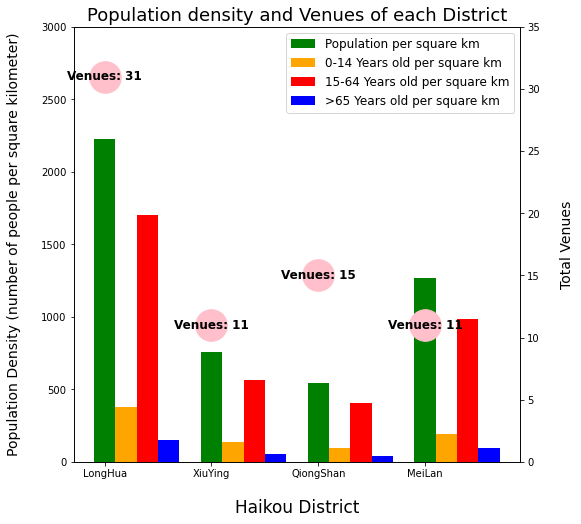

In [30]:
# firt figure will show the put-together data of distict-venues-population
cate_x = Haikou_data['District']
colors = ['green', 'orange','red','blue']
values = np.array([Haikou_data_2.iloc[:,5], Haikou_data_2.iloc[:,6], Haikou_data_2.iloc[:,7], Haikou_data_2.iloc[:,8]])
number_groups = len(cate_x)
bin_width = 1.0/(number_groups + 1)
index = np.array(Haikou_data_2.columns[5:])


fig, ax1 = plt.subplots(figsize = (8,8))
ax2 = ax1.twinx()
for i in range(len(cate_x)):
    ax1.bar(x = np.arange(len(cate_x)) + i * bin_width, height = values[i], width = bin_width, color = colors[i], align = 'center')
    ax1.set_xticks(np.arange(len(cate_x)) + number_groups/(2*(number_groups+1)))
    ax1.set_xticklabels(cate_x)
    ax1.legend(index, facecolor = 'w', fontsize = 12)
ax1.set_xlabel('Haikou District',fontsize = 17, labelpad = 20)
ax1.set_ylabel('Population Density (number of people per square kilometer)',fontsize = 14,labelpad = 20)
ax1.set_ylim(0,3000)

ax2.scatter(Haikou_venues_district.index, Haikou_venues_district.values, s = 1000, color = 'pink', marker = 'o' )
ax2.set_ylabel('Total Venues',fontsize = 14,labelpad = 20)
ax2.set_ylim(0,35)
for a, b in zip(Haikou_venues_district.index, Haikou_venues_district.values):
    ax2.text(a, b, 'Venues: %.0f'%b, ha = 'center', va ='center', weight = 'bold', c = 'black', fontsize = 12)
ax1.set_title('Population density and Venues of each District' , size=18)
plt.show()


### 4.2 Analysis of GDP, Salary and Home Price

In [31]:
# arrange the data
price = Haikou_data_2[['District','GDP Per Capital (RMB)','salary (RMB)','Home Price (RMB)']]
price['GDP : Home Price'] = price.loc[:,'GDP Per Capital (RMB)']/price.loc[:,'Home Price (RMB)']
price['Salary : Home Price'] = price.loc[:,'salary (RMB)']/price.loc[:,'Home Price (RMB)']
price

<ipython-input-31-497bc0f7b5f3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['GDP : Home Price'] = price.loc[:,'GDP Per Capital (RMB)']/price.loc[:,'Home Price (RMB)']
<ipython-input-31-497bc0f7b5f3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['Salary : Home Price'] = price.loc[:,'salary (RMB)']/price.loc[:,'Home Price (RMB)']


,District,GDP Per Capital (RMB),salary (RMB),Home Price (RMB),GDP : Home Price,Salary : Home Price
0,LongHua,102626.157062,34220.0,14664,6.99851,2.33361
1,XiuYing,56781.846313,30428.0,16826,3.37465,1.80839
2,QiongShan,33234.316983,31405.0,13669,2.43136,2.29753
3,MeiLan,51792.828685,31503.0,16263,3.1847,1.9371


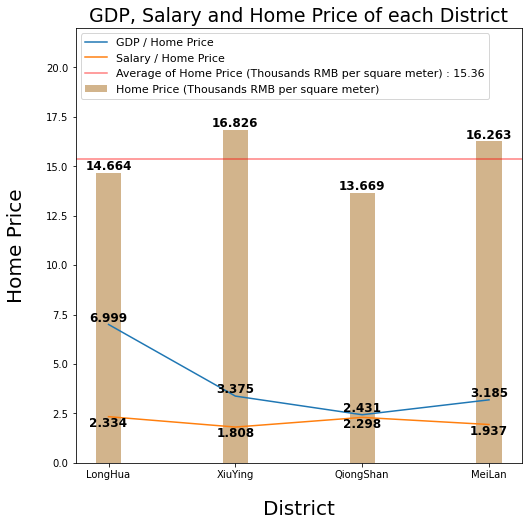

In [32]:
plt.figure(figsize = (8,8))

plt.bar(price['District'], price['Home Price (RMB)']/1000, width = bin_width, color = 'tan', align = 'center', label = 'Home Price (Thousands RMB per square meter)')
plt.plot(price['District'], price['GDP : Home Price'], label = 'GDP / Home Price')
plt.plot(price['District'], price['Salary : Home Price'], label = 'Salary / Home Price')

for a, b in zip(price['District'], price['Home Price (RMB)']/1000):
    plt.text(a, b, '%.3f'%b, ha = 'center', va ='bottom', weight = 'bold', c = 'black', fontsize = 12)
for a, b in zip(price['District'], price['GDP : Home Price']):
    plt.text(a, b, '%.3f'%b, ha = 'center', va ='bottom', weight = 'bold', c = 'black', fontsize = 12)
for a, b in zip(price['District'], price['Salary : Home Price']):
    plt.text(a, b, '%.3f'%b, ha = 'center', va ='top', weight = 'bold', c = 'black', fontsize = 12)

threshold = ((price['Home Price (RMB)'].mean())/1000).round(2)
plt.axhline(y = threshold, color = 'red', alpha = 0.5, label = 'Average of Home Price (Thousands RMB per square meter) : {}'.format(threshold))
plt.ylim(0,22)
plt.legend(loc='upper left',fontsize = 11)
plt.title('GDP, Salary and Home Price of each District', fontsize = 19)
plt.rc('xtick',labelsize = 14)
plt.rc('ytick',labelsize = 14)
plt.xlabel('District',fontsize = 20,labelpad = 20)
plt.ylabel('Home Price',fontsize = 20,labelpad = 20)
plt.show()

 ### 4.3 Venues of each Neighborhood

## 4.3.1 Prepare the data (each venue for every district)

In [33]:
# find hot spot of each category
Haikou_hot = pd.get_dummies(Haikou_venues_data[['V Category']], prefix="", prefix_sep="")

# Add District and neighborhood column back to dataframe
Haikou_hot['District'] = Haikou_venues_data['District']
Haikou_hot['Neighborhood'] = Haikou_venues_data['Neighborhood']

# Move these columns to the first column
new_columns = [Haikou_hot.columns[-1]] + [Haikou_hot.columns[-2]] + list(Haikou_hot.columns[:-2])
Haikou_hot = Haikou_hot[new_columns]


In [41]:
# Group by
Haikou_grouped = Haikou_hot.groupby(['Neighborhood','District']).sum().reset_index()
Haikou_grouped = Haikou_grouped.sort_values(by=['District'])


In [35]:
# Haikou_grouped_2 = Haikou_grouped.replace(0,np.nan).dropna(axis = 1)
lis_t = []
for i in range(len(Haikou_grouped.columns)):
    lis_t.append(Haikou_grouped.iloc[:,i].sum())
Haikou_grouped.loc['total'] = lis_t   
Haikou_grouped.iloc[-1,0] = 'Total'
Haikou_grouped.iloc[-1,1] = 'Total'
Haikou_grouped

,Neighborhood,District,Asian Restaurant,BBQ Joint,Bar,Boat or Ferry,Café,Chinese Restaurant,Clothing Store,Coffee Shop,...,Pizza Place,Resort,Restaurant,Seafood Restaurant,Shopping Mall,Snack Place,Soccer Stadium,Supermarket,Train Station,Women's Store
7,Haikou Gymnasium,LongHua,0,0,0,0,0,0,0,1,...,1,0,0,0,1,0,0,0,0,0
8,Hainan Exhibition Convention Center,LongHua,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
9,Jinniuling Park,LongHua,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
11,People's Park,LongHua,1,0,0,0,0,0,0,0,...,1,0,0,0,3,0,0,1,0,1
14,Xiuying Fort,LongHua,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
15,Yusha Capital City,LongHua,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,Baishamen,MeiLan,0,0,0,0,1,1,0,0,...,0,0,0,1,0,0,0,0,0,0
3,HAIDIAN,MeiLan,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
13,XINBU,MeiLan,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
1,DAOKECUN,QiongShan,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
LongHua_v = Haikou_grouped[Haikou_grouped['District'] == "LongHua"]

In [37]:
# prepare the venues category for LongHua district
LongHua_v = Haikou_grouped[Haikou_grouped['District'] == "LongHua"]
LongHua_l = []
for i in range(len(LongHua_v.columns)):
    LongHua_l.append(LongHua_v.iloc[:,i].sum())
LongHua_v.loc['total'] = LongHua_l  
LongHua_v.iloc[-1,0] = 'Total'
LongHua_v.iloc[-1,1] = 'LongHua'
LongHua_v_data = LongHua_v[LongHua_v['Neighborhood'] == "Total"]
# delete the category with value of 0
LongHua_v_data = LongHua_v_data.replace(0,np.nan)
LongHua_v_data = LongHua_v_data.dropna(axis = 1)
LongHua_v_data = LongHua_v_data.drop(columns = ['Neighborhood','District'])

c:\users\xiang fu\appdata\local\programs\python\python38-32\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
c:\users\xiang fu\appdata\local\programs\python\python38-32\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [36]:
LongHua_welcome = LongHua_venues.sort_values(by=['Venues'],ascending=False)
LongHua_welcome

Venues
District Neighborhood                               
LongHua  People's Park                            12
         Haikou Gymnasium                          7
         Jinniuling Park                           5
         Xiuying Fort                              3
         Hainan Exhibition Convention Center       2
         Yusha Capital City                        2

In [37]:
# find venues of sub_places of LongHua District
People_park =LongHua_v[LongHua_v['Neighborhood'] == "People's Park"]
People_park = People_park.replace(0,np.nan)
People_park = People_park.dropna(axis=1)

Haikou_Gymnasium = LongHua_v[LongHua_v['Neighborhood'] == "Haikou Gymnasium"]
Haikou_Gymnasium = Haikou_Gymnasium.replace(0,np.nan)
Haikou_Gymnasium = Haikou_Gymnasium.dropna(axis=1)

Jinniuling_Park = LongHua_v[LongHua_v['Neighborhood'] == "Jinniuling Park"]
Jinniuling_Park = Jinniuling_Park.replace(0,np.nan)
Jinniuling_Park = Jinniuling_Park.dropna(axis=1)

Xiuying_Fort =LongHua_v[LongHua_v['Neighborhood'] == "Xiuying Fort"]
Xiuying_Fort = Xiuying_Fort.replace(0,np.nan)
Xiuying_Fort = Xiuying_Fort.dropna(axis=1)

Hainan_Exhibition =LongHua_v[LongHua_v['Neighborhood'] == "Hainan Exhibition Convention Center"]
Hainan_Exhibition = Hainan_Exhibition.replace(0,np.nan)
Hainan_Exhibition = Hainan_Exhibition.dropna(axis=1)

Yusha =LongHua_v[LongHua_v['Neighborhood'] == "Yusha Capital City"]
Yusha = Yusha.replace(0,np.nan)
Yusha = Yusha.dropna(axis=1)

In [38]:
# DO so for the rest of the Districts

XiuYing_v = Haikou_grouped[Haikou_grouped['District'] == "XiuYing"]
XiuYing_l = []
for i in range(len(XiuYing_v.columns)):
    XiuYing_l.append(XiuYing_v.iloc[:,i].sum())
XiuYing_v.loc['total'] = XiuYing_l   
XiuYing_v.iloc[-1,0] = 'Total'
XiuYing_v.iloc[-1,1] = 'XiuYing'
XiuYing_v_data = XiuYing_v[XiuYing_v['Neighborhood'] == "Total"]
# delete the category with value of 0
XiuYing_v_data = XiuYing_v_data.replace(0,np.nan)
XiuYing_v_data = XiuYing_v_data.dropna(axis = 1)
XiuYing_v_data = XiuYing_v_data.drop(columns = ['Neighborhood','District'])

QiongShan_v = Haikou_grouped[Haikou_grouped['District'] == "QiongShan"]
QiongShan_l = []
for i in range(len(QiongShan_v.columns)):
    QiongShan_l.append(QiongShan_v.iloc[:,i].sum())
QiongShan_v.loc['total'] = QiongShan_l   
QiongShan_v.iloc[-1,0] = 'Total'
QiongShan_v.iloc[-1,1] = 'QiongShan'
QiongShan_v_data = QiongShan_v[QiongShan_v['Neighborhood'] == "Total"]
# delete the category with value of 0
QiongShan_v_data = QiongShan_v_data.replace(0,np.nan)
QiongShan_v_data = QiongShan_v_data.dropna(axis = 1)
QiongShan_v_data = QiongShan_v_data.drop(columns = ['Neighborhood','District'])

MeiLan_v = Haikou_grouped[Haikou_grouped['District'] == "MeiLan"]
MeiLan_l = []
for i in range(len(MeiLan_v.columns)):
    MeiLan_l.append(MeiLan_v.iloc[:,i].sum())
MeiLan_v.loc['total'] = MeiLan_l   
MeiLan_v.iloc[-1,0] = 'Total'
MeiLan_v.iloc[-1,1] = 'MeiLan'
MeiLan_v_data = MeiLan_v[MeiLan_v['Neighborhood'] == "Total"]
# delete the category with value of 0
MeiLan_v_data = MeiLan_v_data.replace(0,np.nan)
MeiLan_v_data = MeiLan_v_data.dropna(axis = 1)
MeiLan_v_data = MeiLan_v_data.drop(columns = ['Neighborhood','District'])


c:\users\xiang fu\appdata\local\programs\python\python38-32\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
c:\users\xiang fu\appdata\local\programs\python\python38-32\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [39]:
XiuYing_welcome = XiuYing_venues.sort_values(by=['Venues'],ascending=False)
XiuYing_welcome

Venues
District Neighborhood        
XiuYing  HOUHAI             6
         Haikou Bay         4
         HAIXIUZHEN         1

In [40]:
# find venues of sub_places of XiuYing District
HOUHAI = XiuYing_v[XiuYing_v['Neighborhood'] == "HOUHAI"]
HOUHAI = HOUHAI.replace(0,np.nan)
HOUHAI = HOUHAI.dropna(axis=1)

Haikou_Bay = XiuYing_v[XiuYing_v['Neighborhood'] == "Haikou Bay"]
Haikou_Bay = Haikou_Bay.replace(0,np.nan)
Haikou_Bay = Haikou_Bay.dropna(axis=1)

HAIXIUZHEN = XiuYing_v[XiuYing_v['Neighborhood'] == "HAIXIUZHEN"]
HAIXIUZHEN = HAIXIUZHEN.replace(0,np.nan)
HAIXIUZHEN = HAIXIUZHEN.dropna(axis=1)


In [41]:
QiongShan_welcome = QiongShan_venues.sort_values(by=['Venues'],ascending=False)
QiongShan_welcome

Venues
District  Neighborhood                    
QiongShan DINGCUN                        5
          PANDANCUN                      4
          Temple of the Five Lords       4
          DAOKECUN                       2

In [42]:
# find venues of sub_places of QiongShan District
DINGCUN = QiongShan_v[QiongShan_v['Neighborhood'] == "DINGCUN"]
DINGCUN = DINGCUN.replace(0,np.nan)
DINGCUN = DINGCUN.dropna(axis=1)

PANDANCUN = QiongShan_v[QiongShan_v['Neighborhood'] == "PANDANCUN"]
PANDANCUN = PANDANCUN.replace(0,np.nan)
PANDANCUN = PANDANCUN.dropna(axis=1)

Temple = QiongShan_v[QiongShan_v['Neighborhood'] == "Temple of the Five Lords"]
Temple = Temple.replace(0,np.nan)
Temple = Temple.dropna(axis=1)

DAOKECUN = QiongShan_v[QiongShan_v['Neighborhood'] == "DAOKECUN"]
DAOKECUN = DAOKECUN.replace(0,np.nan)
DAOKECUN = DAOKECUN.dropna(axis=1)

In [43]:
MeiLan_welcome = MeiLan_venues.sort_values(by=['Venues'],ascending=False)
MeiLan_welcome

Venues
District Neighborhood        
MeiLan   Baishamen          4
         HAIDIAN            4
         XINBU              3

In [44]:
# find venues of sub_places of MeiLan District
Baishamen = MeiLan_v[MeiLan_v['Neighborhood'] == "Baishamen"]
Baishamen = Baishamen.replace(0,np.nan)
Baishamen = Baishamen.dropna(axis=1)

HAIDIAN = MeiLan_v[MeiLan_v['Neighborhood'] == "HAIDIAN"]
HAIDIAN = HAIDIAN.replace(0,np.nan)
HAIDIAN = HAIDIAN.dropna(axis=1)

XINBU = MeiLan_v[MeiLan_v['Neighborhood'] == "XINBU"]
XINBU = XINBU.replace(0,np.nan)
XINBU = XINBU.dropna(axis=1)

## 4.3.2 Plotting

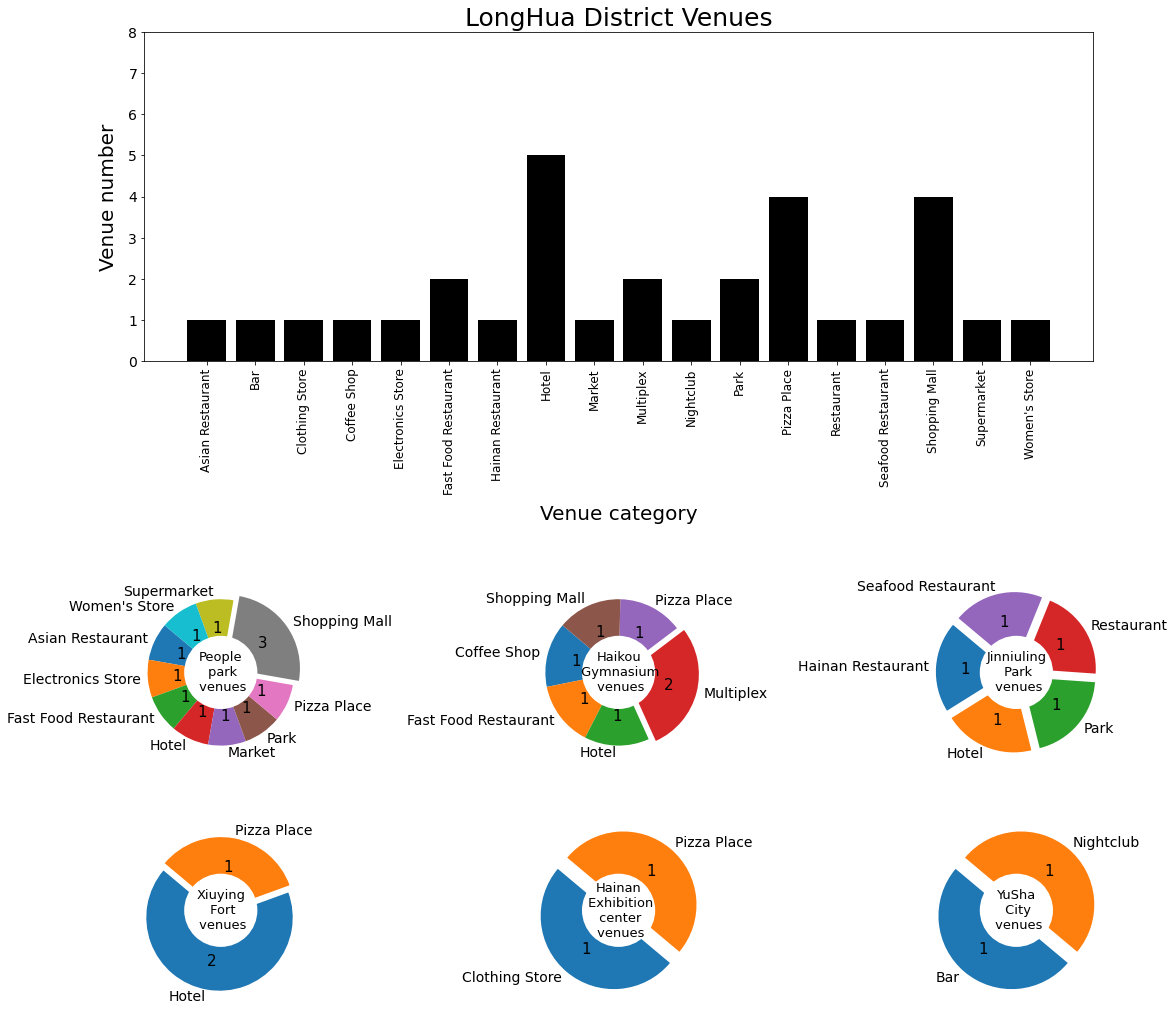

In [45]:
# Plot all the data of venues, copy-paste code for each venue

fig = plt.figure(figsize = (17,17))
gs = gridspec.GridSpec(nrows = 8, ncols = 5, figure = fig, wspace = 0.3, hspace = 0.3 )
ax1 = fig.add_subplot(gs[0:3, 0:5])
ax1.bar(LongHua_v_data.columns, LongHua_v_data.iloc[0], color = 'black', align = 'center', label = 'LongHua Venues')
ax1.set_xticklabels(LongHua_v_data.columns,rotation = 90, fontsize = 12)
ax1.set_ylim(0,8)
ax1.set_xlabel('Venue category',fontsize = 20,labelpad = 10)
ax1.set_ylabel('Venue number',fontsize = 20,labelpad = 10)
ax1.set_title('LongHua District Venues',fontsize = 25)


# sub-2
ax2 = fig.add_subplot(gs[5, 0])
sub_2 = np.squeeze(People_park.iloc[:,2:].values)
sub_2_l = People_park.columns[2:]

expl = []
for i in range(len(sub_2)):
    expl.append(0)
    if sub_2[i] == max(sub_2):
        expl[i] = 0.2
# add exact number of venues on the pie
p,tx,texts = ax2.pie(sub_2,labels = sub_2_l, explode = expl, radius = 2, 
                     pctdistance = 0.6,autopct="",startangle=140)
for i,j in enumerate(texts):
    j.set_text('{}'.format(sub_2[i]))
    j.set_size(15)

center_circle = plt.Circle((0,0),1,fc='white')
fig2 = plt.gcf()
fig2.gca().add_artist(center_circle)
ax2.annotate('People\n park\n venues',xy = (0,0),fontsize = 13,va= 'center',ha='center')


# sub-3
ax3 = fig.add_subplot(gs[5, 2])
sub_3 = np.squeeze(Haikou_Gymnasium.iloc[:,2:].values)
sub_3_l = Haikou_Gymnasium.columns[2:]

expl = []
for i in range(len(sub_3)):
    expl.append(0)
    if sub_3[i] == max(sub_3):
        expl[i] = 0.2
# add exact number of venues on the pie
p,tx,texts = ax3.pie(sub_3,labels = sub_3_l, explode = expl, radius = 2, 
                     pctdistance = 0.6,autopct="",startangle=140)
for i,j in enumerate(texts):
    j.set_text('{}'.format(sub_3[i]))
    j.set_size(15)

center_circle = plt.Circle((0,0),1,fc='white')
fig3 = plt.gcf()
fig3.gca().add_artist(center_circle)
ax3.annotate('Haikou\n Gymnasium\n venues',xy = (0,0),fontsize = 13,va= 'center', ha='center')

#sub-4
ax4 = fig.add_subplot(gs[5, 4])
sub_4 = np.squeeze(Jinniuling_Park.iloc[:,2:].values)
sub_4_l = Jinniuling_Park.columns[2:]

expl = []
for i in range(len(sub_4)):
    expl.append(0)
    if sub_4[i] == max(sub_4):
        expl[i] = 0.2
# add exact number of venues on the pie
p,tx,texts = ax4.pie(sub_4,labels = sub_4_l, explode = expl, radius = 2, 
                     pctdistance = 0.6,autopct="",startangle=140)
for i,j in enumerate(texts):
    j.set_text('{}'.format(sub_4[i]))
    j.set_size(15)

center_circle = plt.Circle((0,0),1,fc='white')
fig4 = plt.gcf()
fig4.gca().add_artist(center_circle)
ax4.annotate('Jinniuling\n Park\n venues',xy = (0,0),fontsize = 13,va= 'center', ha='center')

#sub-5
ax5 = fig.add_subplot(gs[7, 0])
sub_5 = np.squeeze(Xiuying_Fort.iloc[:,2:].values)
sub_5_l = Xiuying_Fort.columns[2:]

expl = []
for i in range(len(sub_5)):
    expl.append(0)
    if sub_5[i] == max(sub_5):
        expl[i] = 0.2
# add exact number of venues on the pie
p,tx,texts = ax5.pie(sub_5,labels = sub_5_l, explode = expl, radius = 2, 
                     pctdistance = 0.6,autopct="",startangle=140)
for i,j in enumerate(texts):
    j.set_text('{}'.format(sub_5[i]))
    j.set_size(15)

center_circle = plt.Circle((0,0),1,fc='white')
fig5 = plt.gcf()
fig5.gca().add_artist(center_circle)
ax5.annotate('Xiuying\n Fort\n venues',xy = (0,0),fontsize = 13,va= 'center', ha='center')

#sub-6
ax6 = fig.add_subplot(gs[7, 2])
sub_6 = np.squeeze(Hainan_Exhibition.iloc[:,2:].values)
sub_6_l = Hainan_Exhibition.columns[2:]

expl = []
for i in range(len(sub_6)):
    expl.append(0)
    if sub_6[i] == max(sub_6):
        expl[i] = 0.2
# add exact number of venues on the pie
p,tx,texts = ax6.pie(sub_6,labels = sub_6_l, explode = expl, radius = 2, 
                     pctdistance = 0.6,autopct="",startangle=140)
for i,j in enumerate(texts):
    j.set_text('{}'.format(sub_6[i]))
    j.set_size(15)

center_circle = plt.Circle((0,0),1,fc='white')
fig6 = plt.gcf()
fig6.gca().add_artist(center_circle)
ax6.annotate('Hainan\n Exhibition\n center\n venues',xy = (0,0),fontsize = 13,va= 'center', ha='center')

#sub-7
ax7 = fig.add_subplot(gs[7, 4])
sub_7 = np.squeeze(Yusha.iloc[:,2:].values)
sub_7_l = Yusha.columns[2:]

expl = []
for i in range(len(sub_7)):
    expl.append(0)
    if sub_7[i] == max(sub_7):
        expl[i] = 0.2
# add exact number of venues on the pie
p,tx,texts = ax7.pie(sub_7,labels = sub_7_l, explode = expl, radius = 2, 
                     pctdistance = 0.6,autopct="",startangle=140)
for i,j in enumerate(texts):
    j.set_text('{}'.format(sub_7[i]))
    j.set_size(15)

center_circle = plt.Circle((0,0),1,fc='white')
fig7 = plt.gcf()
fig7.gca().add_artist(center_circle)
ax7.annotate('YuSha\n City\n venues',xy = (0,0),fontsize = 13,va= 'center', ha='center')


plt.show()



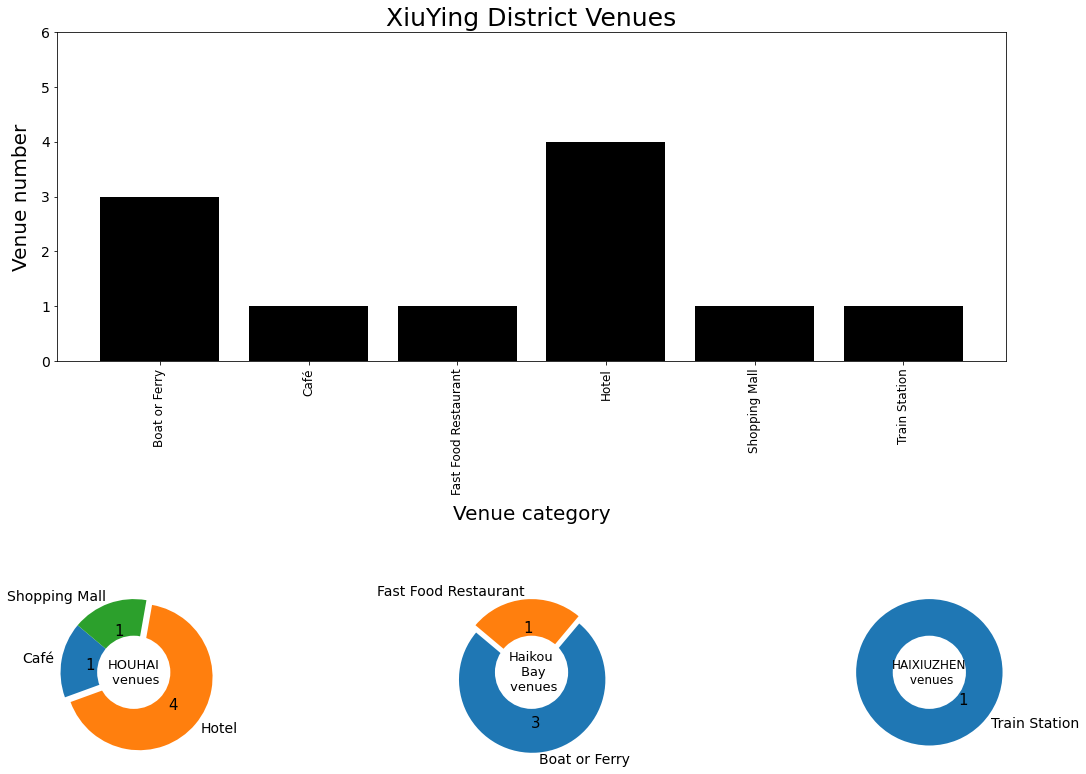

In [46]:
# Plot all the data of XiuYing venues

fig = plt.figure(figsize = (17,17))
gs = gridspec.GridSpec(nrows = 8, ncols = 5, figure = fig, wspace = 0.3, hspace = 0.3 )
ax1 = fig.add_subplot(gs[0:3, 0:5])
ax1.bar(XiuYing_v_data.columns, XiuYing_v_data.iloc[0], color = 'black', align = 'center', label = 'LongHua Venues')
ax1.set_xticklabels(XiuYing_v_data.columns,rotation = 90, fontsize = 12)
ax1.set_ylim(0,6)
ax1.set_xlabel('Venue category',fontsize = 20,labelpad = 10)
ax1.set_ylabel('Venue number',fontsize = 20,labelpad = 10)
ax1.set_title('XiuYing District Venues',fontsize = 25)

# sub-2
ax2 = fig.add_subplot(gs[5, 0])
sub_2 = np.squeeze(HOUHAI.iloc[:,2:].values)
sub_2_l = HOUHAI.columns[2:]

expl = []
for i in range(len(sub_2)):
    expl.append(0)
    if sub_2[i] == max(sub_2):
        expl[i] = 0.2
# add exact number of venues on the pie
p,tx,texts = ax2.pie(sub_2,labels = sub_2_l, explode = expl, radius = 2, 
                     pctdistance = 0.6,autopct="",startangle=140)
for i,j in enumerate(texts):
    j.set_text('{}'.format(sub_2[i]))
    j.set_size(15)

center_circle = plt.Circle((0,0),1,fc='white')
fig2 = plt.gcf()
fig2.gca().add_artist(center_circle)
ax2.annotate('HOUHAI\n venues',xy = (0,0),fontsize = 13,va= 'center',ha='center')


# sub-3
ax3 = fig.add_subplot(gs[5, 2])
sub_3 = np.squeeze(Haikou_Bay.iloc[:,2:].values)
sub_3_l = Haikou_Bay.columns[2:]

expl = []
for i in range(len(sub_3)):
    expl.append(0)
    if sub_3[i] == max(sub_3):
        expl[i] = 0.2
# add exact number of venues on the pie
p,tx,texts = ax3.pie(sub_3,labels = sub_3_l, explode = expl, radius = 2, 
                     pctdistance = 0.6,autopct="",startangle=140)
for i,j in enumerate(texts):
    j.set_text('{}'.format(sub_3[i]))
    j.set_size(15)

center_circle = plt.Circle((0,0),1,fc='white')
fig3 = plt.gcf()
fig3.gca().add_artist(center_circle)
ax3.annotate('Haikou\n Bay\n venues',xy = (0,0),fontsize = 13,va= 'center', ha='center')

#sub-4
ax4 = fig.add_subplot(gs[5, 4])
sub_4 = HAIXIUZHEN.iloc[:,2].values
sub_4_l = HAIXIUZHEN.columns[2:]

p,tx,texts = ax4.pie(sub_4,labels = sub_4_l, radius = 2, 
                     pctdistance = 0.6,autopct="",startangle=140)
for i,j in enumerate(texts):
    j.set_text('{}'.format(sub_4[i]))
    j.set_size(15)

center_circle = plt.Circle((0,0),1,fc='white')
fig4 = plt.gcf()
fig4.gca().add_artist(center_circle)
ax4.annotate('HAIXIUZHEN\n venues',xy = (0,0),fontsize = 12,va= 'center', ha='center')

plt.show()

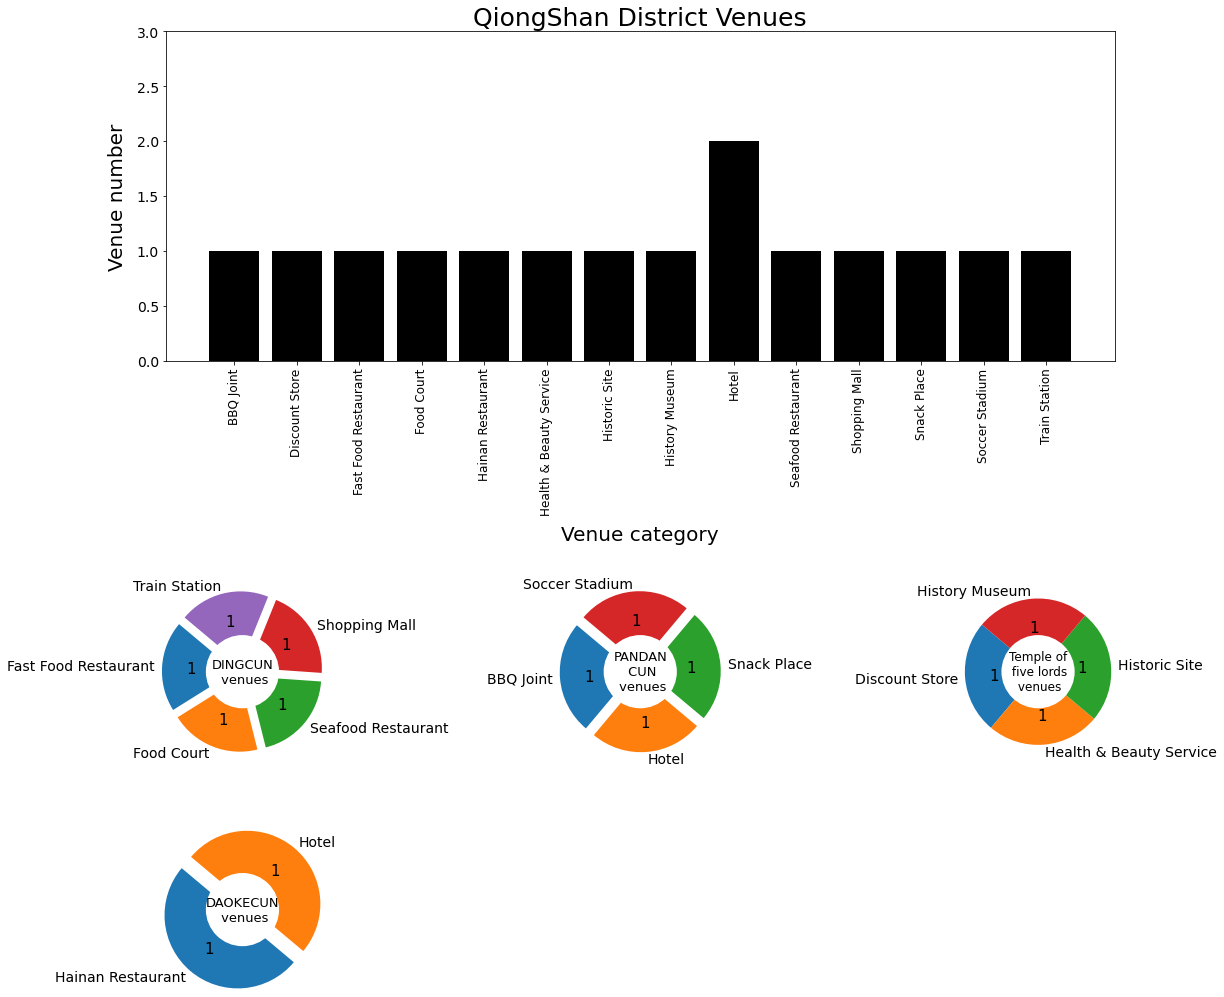

In [47]:
# Plot all the data of QiongShan venues
fig = plt.figure(figsize = (17,17))
gs = gridspec.GridSpec(nrows = 8, ncols = 5, figure = fig, wspace = 0.3, hspace = 0.3 )
ax1 = fig.add_subplot(gs[0:3, 0:5])
ax1.bar(QiongShan_v_data.columns, QiongShan_v_data.iloc[0], color = 'black', align = 'center', label = 'LongHua Venues')
ax1.set_xticklabels(QiongShan_v_data.columns,rotation = 90, fontsize = 12)
ax1.set_ylim(0,3)
ax1.set_xlabel('Venue category',fontsize = 20,labelpad = 10)
ax1.set_ylabel('Venue number',fontsize = 20,labelpad = 10)
ax1.set_title('QiongShan District Venues',fontsize = 25)

# sub-2
ax2 = fig.add_subplot(gs[5, 0])
sub_2 = np.squeeze(DINGCUN.iloc[:,2:].values)
sub_2_l = DINGCUN.columns[2:]

expl = []
for i in range(len(sub_2)):
    expl.append(0)
    if sub_2[i] == max(sub_2):
        expl[i] = 0.2
# add exact number of venues on the pie
p,tx,texts = ax2.pie(sub_2,labels = sub_2_l, explode = expl, radius = 2, 
                     pctdistance = 0.6,autopct="",startangle=140)
for i,j in enumerate(texts):
    j.set_text('{}'.format(sub_2[i]))
    j.set_size(15)

center_circle = plt.Circle((0,0),1,fc='white')
fig2 = plt.gcf()
fig2.gca().add_artist(center_circle)
ax2.annotate('DINGCUN\n venues',xy = (0,0),fontsize = 13,va= 'center',ha='center')


# sub-3
ax3 = fig.add_subplot(gs[5, 2])
sub_3 = np.squeeze(PANDANCUN.iloc[:,2:].values)
sub_3_l = PANDANCUN.columns[2:]

expl = []
for i in range(len(sub_3)):
    expl.append(0)
    if sub_3[i] == max(sub_3):
        expl[i] = 0.2
# add exact number of venues on the pie
p,tx,texts = ax3.pie(sub_3,labels = sub_3_l, explode = expl, radius = 2, 
                     pctdistance = 0.6,autopct="",startangle=140)
for i,j in enumerate(texts):
    j.set_text('{}'.format(sub_3[i]))
    j.set_size(15)

center_circle = plt.Circle((0,0),1,fc='white')
fig3 = plt.gcf()
fig3.gca().add_artist(center_circle)
ax3.annotate('PANDAN\n CUN\n venues',xy = (0,0),fontsize = 13,va= 'center', ha='center')

#sub-4
ax4 = fig.add_subplot(gs[5, 4])
sub_4 = np.squeeze(Temple.iloc[:,2:].values)
sub_4_l = Temple.columns[2:]

expl = []
for i in range(len(sub_4)):
    expl.append(0)
    if sub_4[i] == max(sub_4):
        expl[i] = 0.2
p,tx,texts = ax4.pie(sub_4,labels = sub_4_l, radius = 2, 
                     pctdistance = 0.6,autopct="",startangle=140)
for i,j in enumerate(texts):
    j.set_text('{}'.format(sub_4[i]))
    j.set_size(15)

center_circle = plt.Circle((0,0),1,fc='white')
fig4 = plt.gcf()
fig4.gca().add_artist(center_circle)
ax4.annotate('Temple of\n five lords\n venues',xy = (0,0),fontsize = 12,va= 'center', ha='center')

#sub-5
ax5 = fig.add_subplot(gs[7, 0])
sub_5 = np.squeeze(DAOKECUN.iloc[:,2:].values)
sub_5_l = DAOKECUN.columns[2:]

expl = []
for i in range(len(sub_5)):
    expl.append(0)
    if sub_5[i] == max(sub_5):
        expl[i] = 0.2
# add exact number of venues on the pie
p,tx,texts = ax5.pie(sub_5,labels = sub_5_l, explode = expl, radius = 2, 
                     pctdistance = 0.6,autopct="",startangle=140)
for i,j in enumerate(texts):
    j.set_text('{}'.format(sub_5[i]))
    j.set_size(15)

center_circle = plt.Circle((0,0),1,fc='white')
fig5 = plt.gcf()
fig5.gca().add_artist(center_circle)
ax5.annotate('DAOKECUN\n venues',xy = (0,0),fontsize = 13,va= 'center', ha='center')

plt.show()

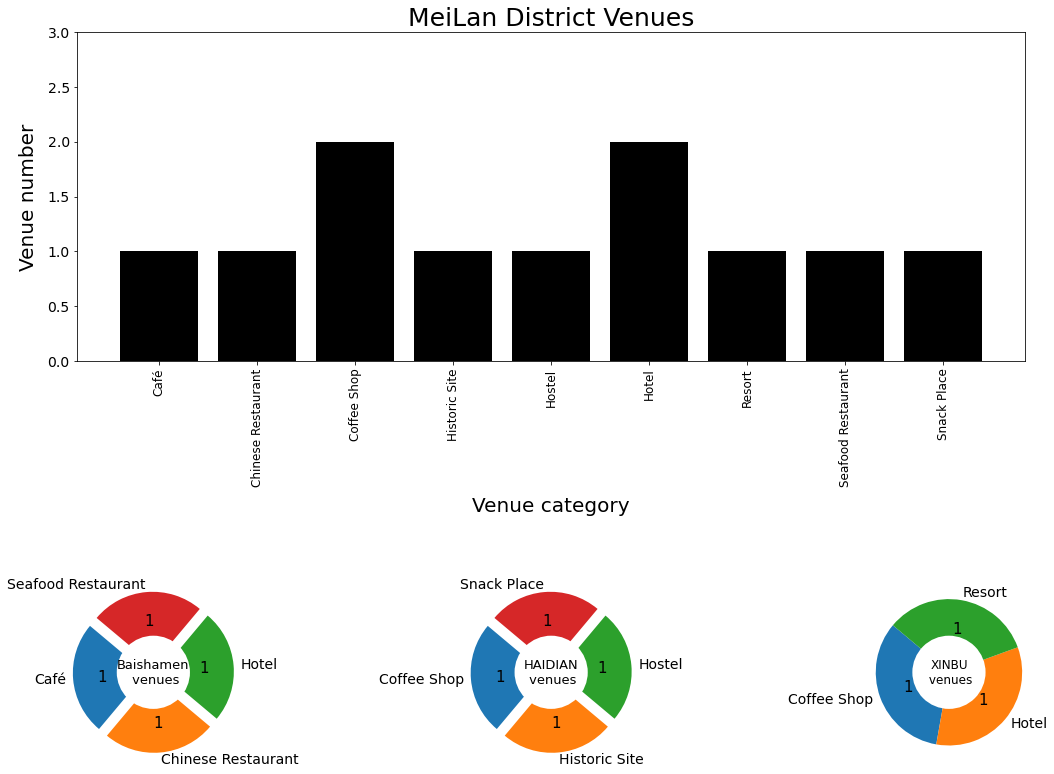

In [48]:
# Plot all the data of MeiLan venues

fig = plt.figure(figsize = (17,17))
gs = gridspec.GridSpec(nrows = 8, ncols = 5, figure = fig, wspace = 0.3, hspace = 0.3 )
ax1 = fig.add_subplot(gs[0:3, 0:5])
ax1.bar(MeiLan_v_data.columns, MeiLan_v_data.iloc[0], color = 'black', align = 'center', label = 'LongHua Venues')
ax1.set_xticklabels(MeiLan_v_data.columns,rotation = 90, fontsize = 12)
ax1.set_ylim(0,3)
ax1.set_xlabel('Venue category',fontsize = 20,labelpad = 10)
ax1.set_ylabel('Venue number',fontsize = 20,labelpad = 10)
ax1.set_title('MeiLan District Venues',fontsize = 25)


# sub-2
ax2 = fig.add_subplot(gs[5, 0])
sub_2 = np.squeeze(Baishamen.iloc[:,2:].values)
sub_2_l = Baishamen.columns[2:]

expl = []
for i in range(len(sub_2)):
    expl.append(0)
    if sub_2[i] == max(sub_2):
        expl[i] = 0.2
# add exact number of venues on the pie
p,tx,texts = ax2.pie(sub_2,labels = sub_2_l, explode = expl, radius = 2, 
                     pctdistance = 0.6,autopct="",startangle=140)
for i,j in enumerate(texts):
    j.set_text('{}'.format(sub_2[i]))
    j.set_size(15)

center_circle = plt.Circle((0,0),1,fc='white')
fig2 = plt.gcf()
fig2.gca().add_artist(center_circle)
ax2.annotate('Baishamen\n venues',xy = (0,0),fontsize = 13,va= 'center',ha='center')


# sub-3
ax3 = fig.add_subplot(gs[5, 2])
sub_3 = np.squeeze(HAIDIAN.iloc[:,2:].values)
sub_3_l = HAIDIAN.columns[2:]

expl = []
for i in range(len(sub_3)):
    expl.append(0)
    if sub_3[i] == max(sub_3):
        expl[i] = 0.2
# add exact number of venues on the pie
p,tx,texts = ax3.pie(sub_3,labels = sub_3_l, explode = expl, radius = 2, 
                     pctdistance = 0.6,autopct="",startangle=140)
for i,j in enumerate(texts):
    j.set_text('{}'.format(sub_3[i]))
    j.set_size(15)

center_circle = plt.Circle((0,0),1,fc='white')
fig3 = plt.gcf()
fig3.gca().add_artist(center_circle)
ax3.annotate('HAIDIAN\n venues',xy = (0,0),fontsize = 13,va= 'center', ha='center')

#sub-4
ax4 = fig.add_subplot(gs[5, 4])
sub_4 = np.squeeze(XINBU.iloc[:,2:].values)
sub_4_l = XINBU.columns[2:]

p,tx,texts = ax4.pie(sub_4,labels = sub_4_l, radius = 2, 
                     pctdistance = 0.6,autopct="",startangle=140)
for i,j in enumerate(texts):
    j.set_text('{}'.format(sub_4[i]))
    j.set_size(15)

center_circle = plt.Circle((0,0),1,fc='white')
fig4 = plt.gcf()
fig4.gca().add_artist(center_circle)
ax4.annotate('XINBU\n venues',xy = (0,0),fontsize = 12,va= 'center', ha='center')

plt.show()

## 5. Visualization of the venues

In [192]:
# make a category list
category = Haikou_venues_data['V Category']
category = category.drop_duplicates() 
category = pd.DataFrame(category)
category

,V Category
0,Pizza Place
1,Fast Food Restaurant
2,Coffee Shop
3,Multiplex
5,Hotel
6,Shopping Mall
13,Clothing Store
14,Hainan Restaurant
15,Seafood Restaurant
16,Park


In [227]:

def Haikou_check(cate, zoom_size):
    
    # Base map characteristic
    map_Haikou = folium.Map(location=[Lat, Long], zoom_start = zoom_size)
    
    Districts = ['LongHua','XiuYing','QiongShan','MeiLan']
    
    colors = ['red','blue','orange','green']
    
    # make the index for specific category
    if cate != 0:
        cate = Haikou_venues_data[Haikou_venues_data['V Category'] == cate]
    else:
        cate = Haikou_venues_data
        
    for lat, lng, label,category,district,nbh in zip(cate['V Latitude'],
                                        cate['V Longitude'],
                                        cate['Venue(V)'],
                                        cate['V Category'],
                                        cate['District'],
                                        cate['Neighborhood']):
        label = folium.Popup(str(label)+', '+str(category)+', '+str(nbh)+', '+str(district), parse_html=False)
        
        folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        color = colors[Districts.index(district)],
        fill = True,
        fill_color = colors[Districts.index(district)],
        fill_opacity = 0.5,
        parse_html=False).add_to(map_Haikou)  
    
    return(map_Haikou)

In [228]:
# Draw map using the index, input the the venue type and the zoom_size of the map into the parenthess
Haikou_check('Hotel',12)

In [230]:
# find all Pizza Place
Haikou_check('Pizza Place',14)

In [234]:
Haikou_check('Shopping Mall',16)

In [204]:
# or input 0 for the all the venues in the map:
Haikou_check(0,12)